In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simulators.jla_supernovae.jla_simulator as jla
import ndes.ndes as ndes
import delfi.delfi as delfi
import compression.score.score as score
import distributions.priors as priors
import tensorflow as tf
import getdist
from getdist import plots, MCSamples
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
### SET UP FOR SIMULATION CODE ###

# Set up the model (imports covariance matrices etc)
JLASimulator = jla.JLA_Model()

# Simulator function: This must be of the form simulator(theta, seed, args) -> simulated data vector
def simulator(theta, seed, simulator_args, batch):
    
    return JLASimulator.simulation(theta, seed)

# Simulator arguments
simulator_args = None

/Users/justinalsing/Dropbox/science/delfi/master/delfi/simulators/jla_supernovae/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


In [3]:
### SET UP THE PRIOR ###

# Define prior limits and boundaries
lower = np.array([0, -1.5, -20, 0, 0, -0.5])
upper = np.array([0.6, 0, -18, 1, 6, 0.5])
prior_covariance = np.diag([0.4, 0.75, 0.1, 0.025, 0.25, 0.05])**2
prior_covariance[0,1] = prior_covariance[1,0] = -0.8*0.4*0.75
prior_mean = np.array([  0.3  ,  -0.75 , -19.05 ,   0.125,   2.6  ,  -0.05 ])
prior = priors.TruncatedGaussian(prior_mean, prior_covariance, lower, upper)

In [4]:
### SET UP THE COMPRESSOR ###

# Fiducial parameters
theta_fiducial = np.array([  0.20181324,  -0.74762939, -19.04253368,   0.12566322,   2.64387045, -0.05252869])

# Expected data (mean) and covariance
mu = JLASimulator.apparent_magnitude(theta_fiducial)
Cinv = JLASimulator.Cinv

# Calculate derivatives of the expected power spectrum
h = np.array(abs(theta_fiducial))*0.01
dmudt = JLASimulator.dmudt(theta_fiducial, h)

# Define compression as score-MLE of a Wishart likelihood
Compressor = score.Gaussian(len(JLASimulator.data), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt, prior_mean = prior_mean, prior_covariance = prior_covariance)

# Compute the Fisher matrix
Compressor.compute_fisher()

# Pull out Fisher matrix inverse
Finv = Compressor.Finv

# Compressor function: This must have the form compressor(data, args) -> compressed summaries (pseudoMLE)
def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args = None

In [5]:
### LOAD IN THE DATA VECTOR ###
compressed_data = compressor(JLASimulator.data, compressor_args)

In [6]:
# MDN version
NDEs = [ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=6, n_data=6, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

# Create the DELFI object
DelfiMDN = delfi.Delfi(compressed_data, prior, NDEs, Finv=Finv, theta_fiducial=theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M'], 
                       results_dir = "simulators/jla_supernovae/results/mdn_",
                       input_normalization="fisher", proposal_chain_length=50)

In [ ]:
# Do the Fisher pre-training
DelfiMDN.fisher_pretraining()

In [ ]:
# Initial samples, batch size for population samples, number of populations
n_initial = 200
n_batch = 200
n_populations = 5

# Do the SNL training
DelfiMDN.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=10,
                       save_intermediate_posteriors=True)

Removed no burn in
Removed no burn in


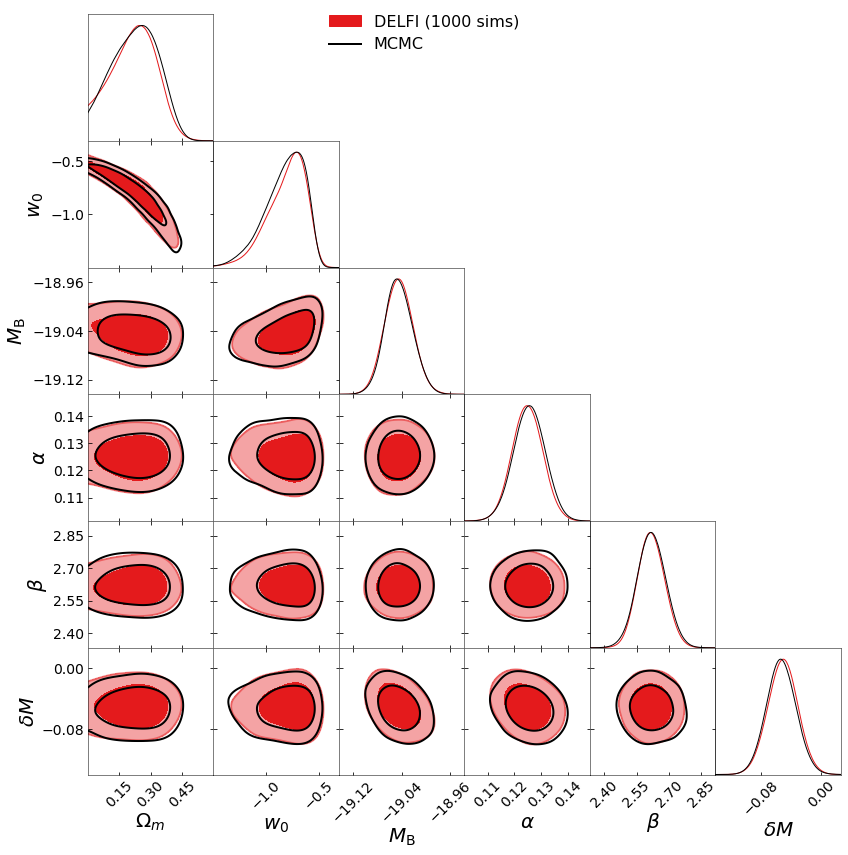

In [12]:
# Compare against MCMC chain

samples_mcmc = np.loadtxt('simulators/jla_supernovae/emcee_samples.dat')
samples_delfi = np.loadtxt('simulators/jla_supernovae/results/mdn_posterior_samples_9.dat')

samples = [samples_delfi, samples_mcmc]
mc_samples = [MCSamples(samples=s, names = DelfiMDN.names, labels = DelfiMDN.labels, ranges = DelfiMDN.ranges) for s in samples]

# Triangle plot

plt.close()
columnwidth = 40 # cm
aspect = 1.67*2
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black'})


g = plots.getSubplotPlotter(width_inch = 12)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.6
g.settings.axes_fontsize=14
g.settings.legend_fontsize=16
g.settings.lab_fontsize=20
g.settings.lw_contour = 2

g.triangle_plot(mc_samples, filled_compare=[True,False,False], normalized=[True,True,True], legend_labels=['Density estimation likelihood-free inference'], contour_lws = [1, 1, 1], contour_ls = ['-','-', '-.'], contour_colors=['#E41A1C','black', 'blue'])
g.add_legend(legend_labels=['DELFI (1000 sims)', 'MCMC'], figure=True)

for i in range(0, len(samples[0][0,:])):
    for j in range(0, i+1):
        ax = g.subplots[i,j]
        xtl = ax.get_xticklabels()
        ax.set_xticklabels(xtl, rotation=45)

plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('simulators/jla_supernovae/jla_contours_mcmc.pdf')